In [1]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

import pandas as pd
import numpy as np
import keras
from keras.utils.data_utils import get_file
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from os.path import join
import multiprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_HOME1 = '/ext_drive/liyin/webface-full-aligned-with-42-margin-resized/'
DATA_HOME2 = '/ext_drive/liyin/celeba-aligned-with-42-margin-resized/'

In [3]:
dataset1 = pd.read_csv('webface-full.aligned.train.csv', nrows=None)
dataset2 = pd.read_csv('celeba.aligned.train.csv', nrows=None)

In [4]:
dataset1['path'] = dataset1['path'].apply(lambda x: join(DATA_HOME1, x))

In [5]:
dataset2['path'] = dataset2['path'].apply(lambda x: join(DATA_HOME2, x))

In [6]:
dataset1.head()

,person,count,path
0,3331486,12,/ext_drive/liyin/webface-full-aligned-with-42-...
1,3331486,12,/ext_drive/liyin/webface-full-aligned-with-42-...
2,3331486,12,/ext_drive/liyin/webface-full-aligned-with-42-...
3,3331486,12,/ext_drive/liyin/webface-full-aligned-with-42-...
4,3331486,12,/ext_drive/liyin/webface-full-aligned-with-42-...


In [7]:
dataset2.head()

,path,count,person
0,/ext_drive/liyin/celeba-aligned-with-42-margin...,20,4386
1,/ext_drive/liyin/celeba-aligned-with-42-margin...,29,7325
2,/ext_drive/liyin/celeba-aligned-with-42-margin...,9,6868
3,/ext_drive/liyin/celeba-aligned-with-42-margin...,26,3213
4,/ext_drive/liyin/celeba-aligned-with-42-margin...,15,1904


In [8]:
dataset = pd.concat([dataset1, dataset2], axis=0).reset_index()

In [9]:
encoder = LabelEncoder()
encoder.fit(dataset['person'])
dataset['person_id'] = encoder.transform(dataset['person'])

In [10]:
dataset.head()

,index,count,path,person,person_id
0,0,12,/ext_drive/liyin/webface-full-aligned-with-42-...,3331486,18508
1,1,12,/ext_drive/liyin/webface-full-aligned-with-42-...,3331486,18508
2,2,12,/ext_drive/liyin/webface-full-aligned-with-42-...,3331486,18508
3,3,12,/ext_drive/liyin/webface-full-aligned-with-42-...,3331486,18508
4,4,12,/ext_drive/liyin/webface-full-aligned-with-42-...,3331486,18508


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655695 entries, 0 to 655694
Data columns (total 5 columns):
index        655695 non-null int64
count        655695 non-null int64
path         655695 non-null object
person       655695 non-null int64
person_id    655695 non-null int64
dtypes: int64(4), object(1)
memory usage: 25.0+ MB


In [12]:
np.mean(dataset.groupby('person_id')['person'].count())

33.741316317604074

In [13]:
# if the count > 30, will random pick 30 + (count-30)*0.2 imgs for the person
import random
random.seed(42)

FACE_NUM = 45

def crit(idx):
    row = dataset.ix[idx]
    count = row['count']
    if count < FACE_NUM: return True
    ratio = (FACE_NUM+(count-FACE_NUM)*0.4) / count
    return random.random() < ratio

def crit2(idx):
    row = dataset.ix[idx]
    count = row['count']
    if count < 6: return True
    return False
    
# dataset = dataset.select(crit)
dataset = pd.concat([dataset, dataset.select(crit2)], axis=0).reset_index()

In [14]:
np.mean(dataset.groupby('person_id')['person'].count())

33.91946688622446

In [15]:
y = dataset['person_id'].as_matrix()

In [16]:
y = np.concatenate([y,y])
y.shape

(1318314,)

In [17]:
img_paths = [r.path for r in dataset.itertuples()]
print(len(img_paths))

659157


In [18]:
img_paths[0]

'/ext_drive/liyin/webface-full-aligned-with-42-margin-resized/3331486/007.png'

In [19]:
from PIL import Image

def path2ImgVec(path):
    x = img_to_array(load_img(path).convert('L'))
    return x.reshape((1,) + x.shape)

def path2ImgVecFlipped(path):
    img = load_img(path).convert('L')
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    x = img_to_array(img)
    return x.reshape((1,) + x.shape)

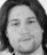

In [20]:
load_img(img_paths[0]).convert('L')

In [21]:
pool = multiprocessing.Pool(8)
results1 = pool.map(path2ImgVec, img_paths)
pool.close()
pool.join()
del pool

In [22]:
pool = multiprocessing.Pool(8)
results2 = pool.map(path2ImgVecFlipped, img_paths)
pool.close()
pool.join()
del pool

In [23]:
X = np.vstack(results1+results2)
# X = np.vstack(results1)

In [24]:
X.shape

(1318314, 55, 47, 1)

In [25]:
for i in range(len(results1)): 
    results1[i] = None
del results1

In [26]:
for i in range(len(results2)): 
    results2[i] = None
del results2

In [27]:
nb_class = len(np.unique(y))
print('nb_class', nb_class)
hidden_dim = 160
best_weights_filepath = '../models/best_weights.hdf5'
input_shape = X.shape[1:]

nb_class 19433


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [29]:
del X, y

In [30]:
import gc
gc.collect()

200

In [31]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from keras.utils import np_utils
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from keras import metrics
from keras.callbacks import Callback
from keras.layers.normalization import BatchNormalization
from keras.engine import Model
from keras import optimizers

def build_model():
    image_input = Input(shape=input_shape)
    
    conv1 = Conv2D(20, (4, 4), name='conv1')(image_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)
#     pool1 = Dropout(rate=0.2)(pool1)
    
    conv2 = Conv2D(40, (3, 3), name='conv2')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)
#     pool2 = Dropout(rate=0.2)(pool2)

    conv3 = Conv2D(60, (3, 3), name='conv3')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)

    flat1 = Flatten(name='flat1')(pool3)
    
    conv4 = Conv2D(80, (2, 2), name='conv4')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    flat2 = Flatten(name='flat2')(conv4)
    
    merged = concatenate([flat1, flat2])
    
    out = Dense(hidden_dim, name='hidden1')(merged)
    out = BatchNormalization()(out)
    out = Activation('relu',name='deepid')(out)
    out = Dense(nb_class, activation='softmax', name='softmax_class')(out)
    
    model = Model(inputs=image_input, outputs=out)

    # optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001)

    model.compile(
        optimizer='adam', #rmsprop
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    print(model.summary())
    return model

In [32]:
model = None
model = build_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 55, 47, 1)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 52, 44, 20)    340                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 52, 44, 20)    80                                           
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 52, 44, 20)    0                                            
___________________________________________________________________________________________

In [33]:
saveBestModel = keras.callbacks.ModelCheckpoint(
    best_weights_filepath, 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    mode='auto'
)
earlyStopping=keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    mode='auto'
)

model.fit(
    X_train, 
    y_train, 
    batch_size=1024, 
    epochs=40,
    verbose=2, 
    validation_split=0.1, 
    shuffle=True,
    callbacks=[saveBestModel, earlyStopping],
)

Train on 1067833 samples, validate on 118649 samples
Epoch 1/40
178s - loss: 6.9981 - acc: 0.0896 - val_loss: 5.5060 - val_acc: 0.1683
Epoch 2/40
175s - loss: 3.9151 - acc: 0.3603 - val_loss: 3.7649 - val_acc: 0.3838
Epoch 3/40
177s - loss: 2.8266 - acc: 0.5105 - val_loss: 3.2534 - val_acc: 0.4544
Epoch 4/40
179s - loss: 2.3047 - acc: 0.5878 - val_loss: 3.0757 - val_acc: 0.4826
Epoch 5/40
181s - loss: 1.9785 - acc: 0.6380 - val_loss: 2.9288 - val_acc: 0.5043
Epoch 6/40
183s - loss: 1.7489 - acc: 0.6738 - val_loss: 2.8019 - val_acc: 0.5237
Epoch 7/40
181s - loss: 1.5773 - acc: 0.7019 - val_loss: 2.8010 - val_acc: 0.5275
Epoch 8/40
181s - loss: 1.4480 - acc: 0.7217 - val_loss: 2.6829 - val_acc: 0.5413
Epoch 9/40
182s - loss: 1.3413 - acc: 0.7390 - val_loss: 2.6706 - val_acc: 0.5461
Epoch 10/40
182s - loss: 1.2547 - acc: 0.7536 - val_loss: 2.6645 - val_acc: 0.5501
Epoch 11/40
182s - loss: 1.1819 - acc: 0.7655 - val_loss: 2.6183 - val_acc: 0.5621
Epoch 12/40
180s - loss: 1.1219 - acc: 0.77

In [34]:
model.load_weights(best_weights_filepath)

In [35]:
model.save('../models/webface-full-celeba-simple-cnn.aligned.margin42.grey.flipped.s40.model.h5')

In [36]:
model.evaluate(X_test, y_test, batch_size=1024, verbose=2)

[2.5350472283700447, 0.5769691729337254]

In [37]:
import gc
gc.collect()

0